In [1]:
from __future__ import division
# 多任务学习，交替训练，联合训练

import os
import tensorflow as tf
from PIL import Image
from nets import nets_factory
import numpy as np
import matplotlib.pyplot as plt


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

In [2]:
# 不同字符数量
CHAR_SET_LEN = 10
# 图片高度
IMAGE_HEIGHT = 60
# 图片高度
IMAGE_WIDTH = 160
# 批次
BATCH_SIZE = 1
# tfrecords文件存放路径
TFRECORD_FILE = ['captcha/images_test_00000-of-00002.tfrecord', 'captcha/images_test_00001-of-00002.tfrecord']

# placeholder
x = tf.placeholder(tf.float32, [None, 224, 224])



# 学习率
lr = tf.Variable(0.003, dtype=tf.float32)

# 从tfrecord读出数据
def read_and_decode(filename):
    # 根据文件名生成一个队列
    filename_queue = tf.train.string_input_producer(filename)
    reader = tf.TFRecordReader()
    # 返回文件名和文件
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                      features={
                                          'image': tf.FixedLenFeature([], tf.string),
                                          'label0': tf.FixedLenFeature([], tf.int64),
                                          'label1': tf.FixedLenFeature([], tf.int64),
                                          'label2': tf.FixedLenFeature([], tf.int64),
                                          'label3': tf.FixedLenFeature([], tf.int64),
                                      })
    
    # 获取图片数据
    image = tf.decode_raw(features['image'], tf.uint8)
    
    # tf.train.shuffle_batch 必须确定shape
    image_raw = tf.reshape(image, [224, 224])
    image = tf.reshape(image, [224, 224])
    
    # 图片预处理
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    
    # 获取label
    label0 = tf.cast(features['label0'], tf.int32)
    label1 = tf.cast(features['label1'], tf.int32)
    label2 = tf.cast(features['label2'], tf.int32)
    label3 = tf.cast(features['label3'], tf.int32)
    
    return image, image_raw, label0, label1, label2, label3



Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from ./captcha/model/crack_captcha.model-6000
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


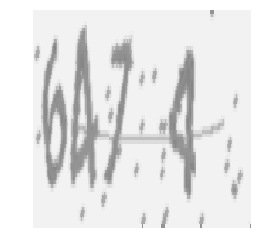

label: 6, 4, 7, 4
predict: 6, 4, 4, 4


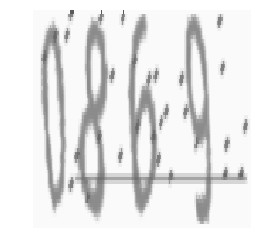

label: 0, 8, 6, 9
predict: 0, 8, 6, 9


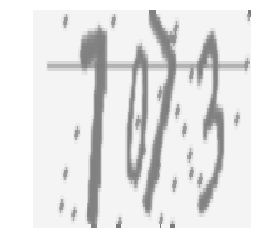

label: 1, 0, 7, 3
predict: 1, 0, 7, 3


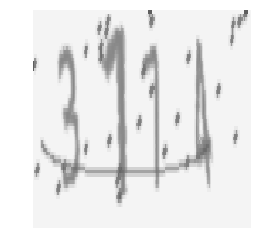

label: 3, 1, 7, 4
predict: 3, 1, 7, 4


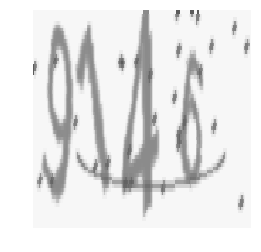

label: 9, 1, 4, 6
predict: 9, 1, 4, 6


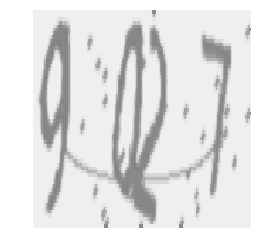

label: 9, 0, 2, 7
predict: 9, 0, 2, 7


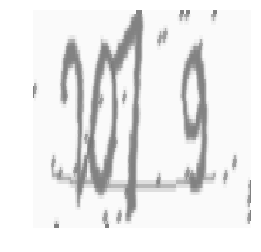

label: 2, 0, 7, 9
predict: 2, 0, 7, 9


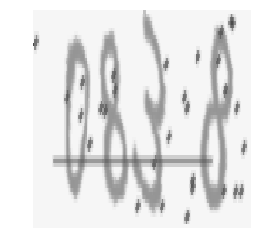

label: 0, 8, 3, 8
predict: 0, 8, 3, 8


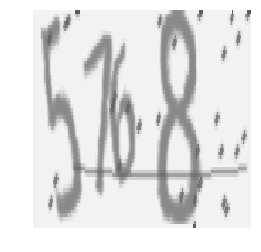

label: 5, 7, 6, 8
predict: 5, 1, 6, 3


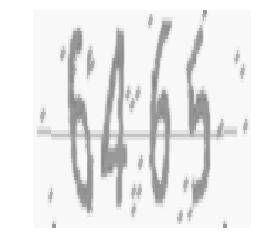

label: 6, 4, 6, 5
predict: 6, 4, 6, 5


In [3]:
# 获取图片数据和标签
image, image_raw, label0, label1, label2, label3 = read_and_decode(TFRECORD_FILE)

# 使用shuffle_batch可以随机打乱
image_batch, image_raw_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch([image, image_raw, label0, label1, label2, label3], batch_size = BATCH_SIZE, capacity = 50000, min_after_dequeue=10000, num_threads=2)
# print image_batch.shape, label_batch0.shape

train_network_fn = nets_factory.get_network_fn('alexnet_v2', num_classes=CHAR_SET_LEN, weight_decay=0.0005, is_training=False)

with tf.Session() as sess:
    # inputs: a tensor of size [batch_size, height, width, channels]
    X = tf.reshape(x, [BATCH_SIZE, 224, 224, 1])
    logits0, logits1, logits2, logits3, end_points = train_network_fn(X)
    
    # 预测值
    predict0 = tf.reshape(logits0, [-1, CHAR_SET_LEN])
    predict0 = tf.argmax(predict0, 1)
    
    predict1 = tf.reshape(logits1, [-1, CHAR_SET_LEN])
    predict1 = tf.argmax(predict1, 1)
    
    predict2 = tf.reshape(logits2, [-1, CHAR_SET_LEN])
    predict2 = tf.argmax(predict2, 1)
    
    predict3 = tf.reshape(logits3, [-1, CHAR_SET_LEN])
    predict3 = tf.argmax(predict3, 1)
    
    # 初始化
    sess.run(tf.global_variables_initializer())
    
    # 用于保存模型
    saver = tf.train.Saver()
    saver.restore(sess, './captcha/model/crack_captcha.model-6000')
    
    
    
    # 创建一个协调器，管理线程
    coord = tf.train.Coordinator()
    # 启动QueueRunner，此时文件名队列已经进队
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    
    for i in range(10):
        # 获取一个批次的数据和标签
        b_image, b_image_raw, b_label0, b_label1, b_label2, b_label3 = sess.run([image_batch, image_raw_batch, label_batch0, label_batch1, label_batch2, label_batch3])
        
        # 显示图片
        img = Image.fromarray(b_image_raw[0], 'L')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        # 打印标签
        print "label: %d, %d, %d, %d" % (b_label0, b_label1, b_label2, b_label3)
        # 预测
        b_label0, b_label1, b_label2, b_label3 = sess.run([predict0, predict1, predict2, predict3], feed_dict={x: b_image})
        
        print "predict: %d, %d, %d, %d" % (b_label0, b_label1, b_label2, b_label3)
    
    # 通知其他线程关闭
    coord.request_stop()
    # 其他所有线程关闭后，这一函数才能返回
    coord.join(threads)